In [1]:
from pathlib import Path
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from astropy import units
import glob

In [2]:
datapath = Path("../data/tr14/")

In [3]:
import tr14_headers

In [4]:
hdrs = tr14_headers.load_headers('pri')

In [61]:
# for i in hdrs.columns:
#     print(i)
hdrs['PA_V3'].unique()

array([55.43248 , 49.958839, 49.999081, 55.84676 , 56.884491, 56.884472,
       55.846741, 55.851181, 55.851231, 55.846722, 55.85125 , 50.003311,
       50.00338 , 55.477169, 56.15612 , 55.84679 , 55.8512  , 50.003269,
       55.4772  , 55.846729, 55.432461, 49.999088, 56.200901, 56.20079 ,
       50.00333 , 49.9991  , 50.003349, 55.432499, 49.958858, 56.888962,
       56.156109, 56.156151, 56.889019, 56.884529, 56.200878, 55.846699,
       55.432468, 50.003342, 56.889   , 56.20089 , 55.477211, 49.958889,
       56.156132, 55.846771, 49.95887 , 55.851219, 49.99913 , 49.999119,
       49.9589  , 49.999111, 49.958912, 55.43243 , 55.47718 , 56.884449,
       55.477139, 50.003288, 50.003361, 56.889042, 56.884499, 55.43251 ,
       56.156101, 56.20084 , 49.958931, 49.99905 , 56.888981, 49.999069,
       56.200871, 55.47723 , 55.851151, 50.003319, 55.477119, 49.999062,
       56.88448 , 55.432449, 56.88446 , 55.851189, 55.477161, 56.88903 ,
       56.889011, 56.888931, 56.200821, 56.15609 , 

In [5]:
full_imgs_df = hdrs.query("SUBTYPE=='FULLIMAG'")

In [6]:
ff_hdr = full_imgs_df.loc[full_imgs_df.index[0]]

In [13]:
hdulist = fits.open(datapath / ff_hdr['FILENAME'])
data = hdulist[1].data
hdulist.close()

In [8]:
# ROOTNAME is the unique file identifier
img_hdr = tr14_headers.load_headers('sci').query(f"ROOTNAME == '{ff_hdr['ROOTNAME']}'")

In [15]:
img_hdr

XTENSION  BITPIX  NAXIS  NAXIS1  NAXIS2  PCOUNT  GCOUNT  \
7    IMAGE     -32      2    1014    1014       0       1   

                     ORIGIN        DATE  INHERIT  ... CTYPE2B  CRVAL1B  \
7  HSTIO/CFITSIO March 2010  2019-12-30     True  ...     NaN      NaN   

  CRVAL2B LONPOLEB LATPOLEB  RADESYSB  CD1_1B  CD1_2B  CD2_1B  CD2_2B  
7     NaN      NaN      NaN       NaN     NaN     NaN     NaN     NaN  

[1 rows x 167 columns]

In [16]:
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.cmap'] = 'magma'

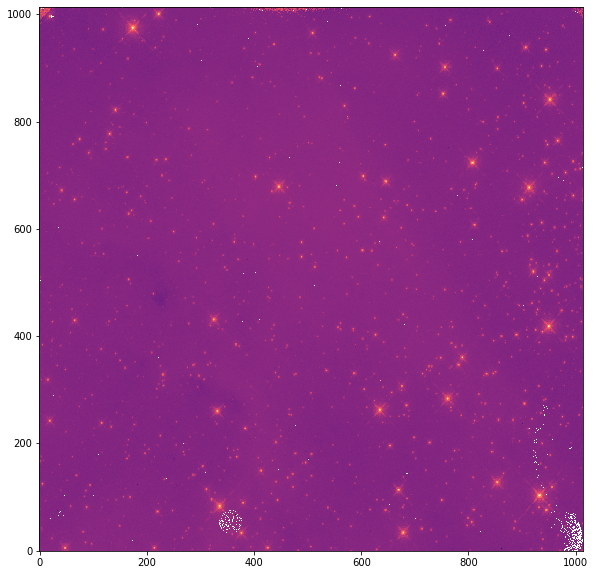

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(data, norm=mpl.colors.LogNorm())

# Load source finding packages

In [18]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std)) 

(6.954757, 6.8444066, 1.1888484)


In [37]:
from photutils import DAOStarFinder, IRAFStarFinder, find_peaks

In [35]:
from astropy.visualization import SqrtStretch,  LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

## DAOStarFinder

In [37]:
daofind = DAOStarFinder(fwhm=1.5, threshold=5.*std)  
dao_sources = daofind(data - median).to_pandas()
print(dao_sources.shape)

(1872, 11)


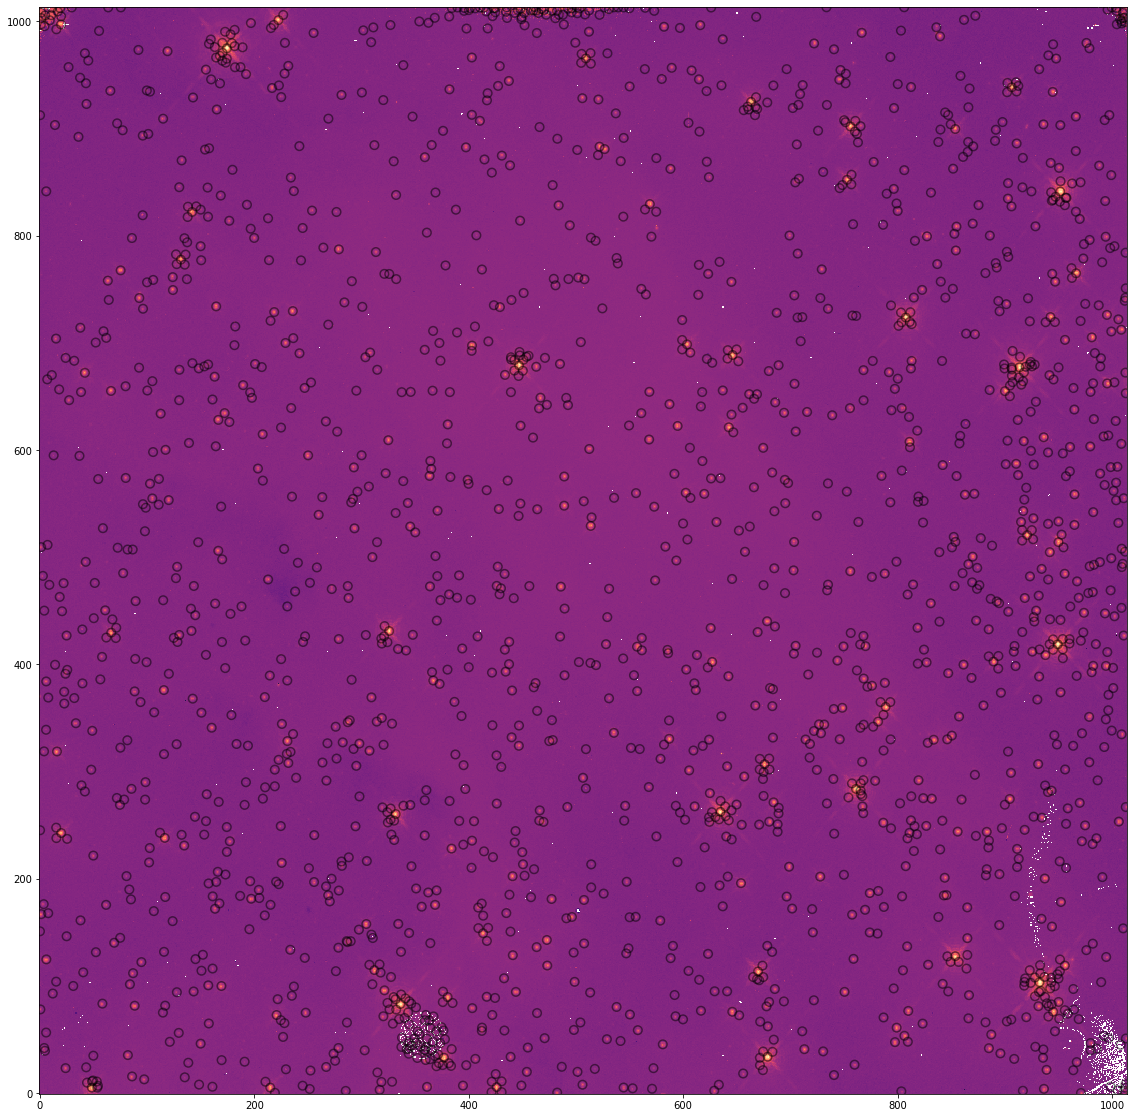

In [43]:
positions = np.transpose((dao_sources['xcentroid'], dao_sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=LogStretch())
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='k', lw=1.5, alpha=0.5)

## IRAFStarFinder

In [38]:
iraffind = IRAFStarFinder(fwhm=1.5, threshold=5.*std)  
iraf_sources = iraffind(data - median).to_pandas()
print(iraf_sources.shape)

(1304, 12)


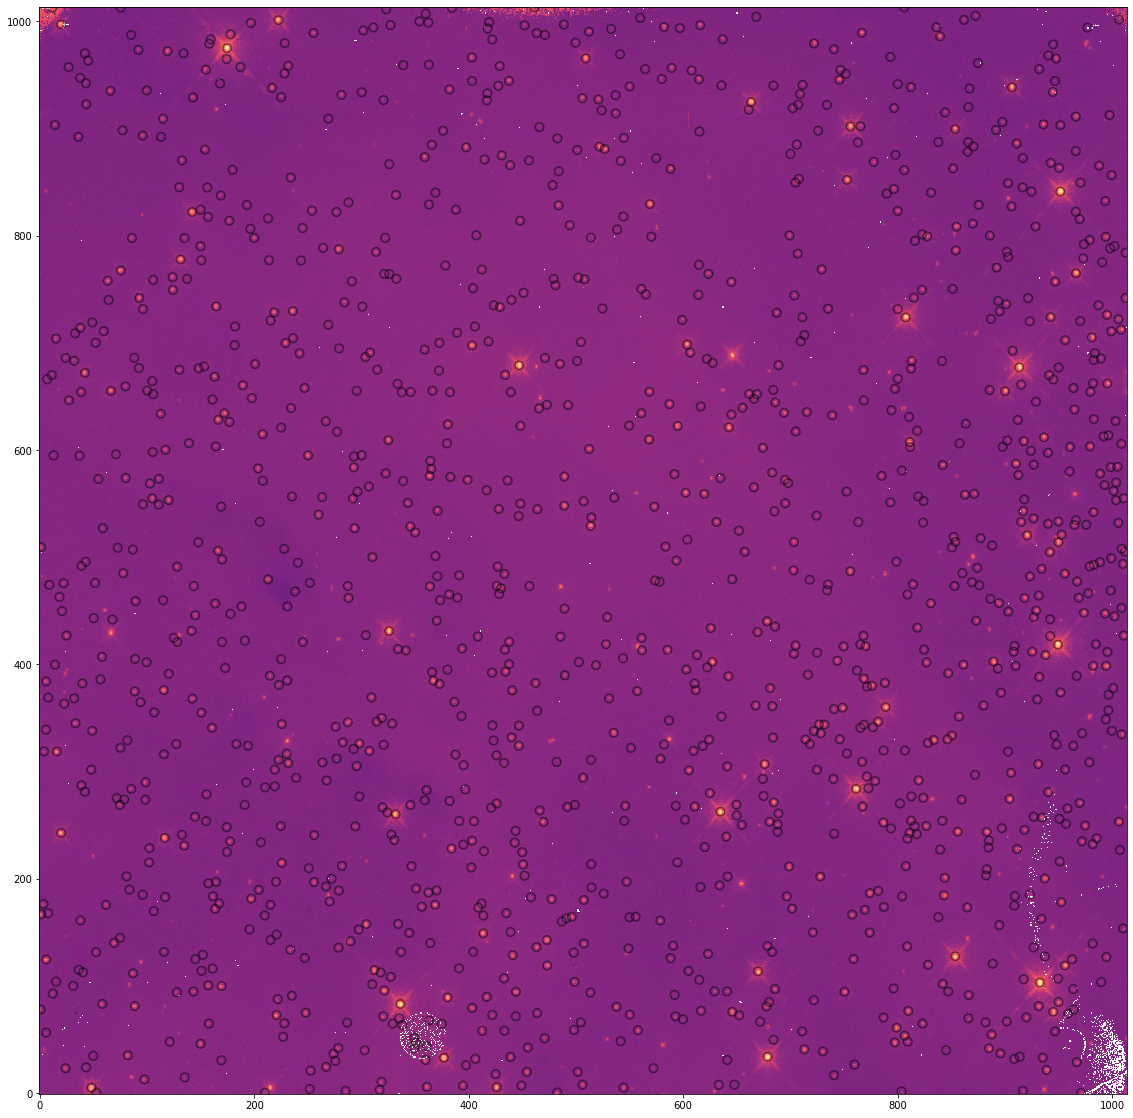

In [42]:
positions = np.transpose((iraf_sources['xcentroid'], iraf_sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=LogStretch())
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='k', lw=1.5, alpha=0.5)

## find_peaks()

In [53]:
threshold = median + (5. * std)
tbl = find_peaks(data, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(len(tbl))  # print only the first 10 peaks

1771


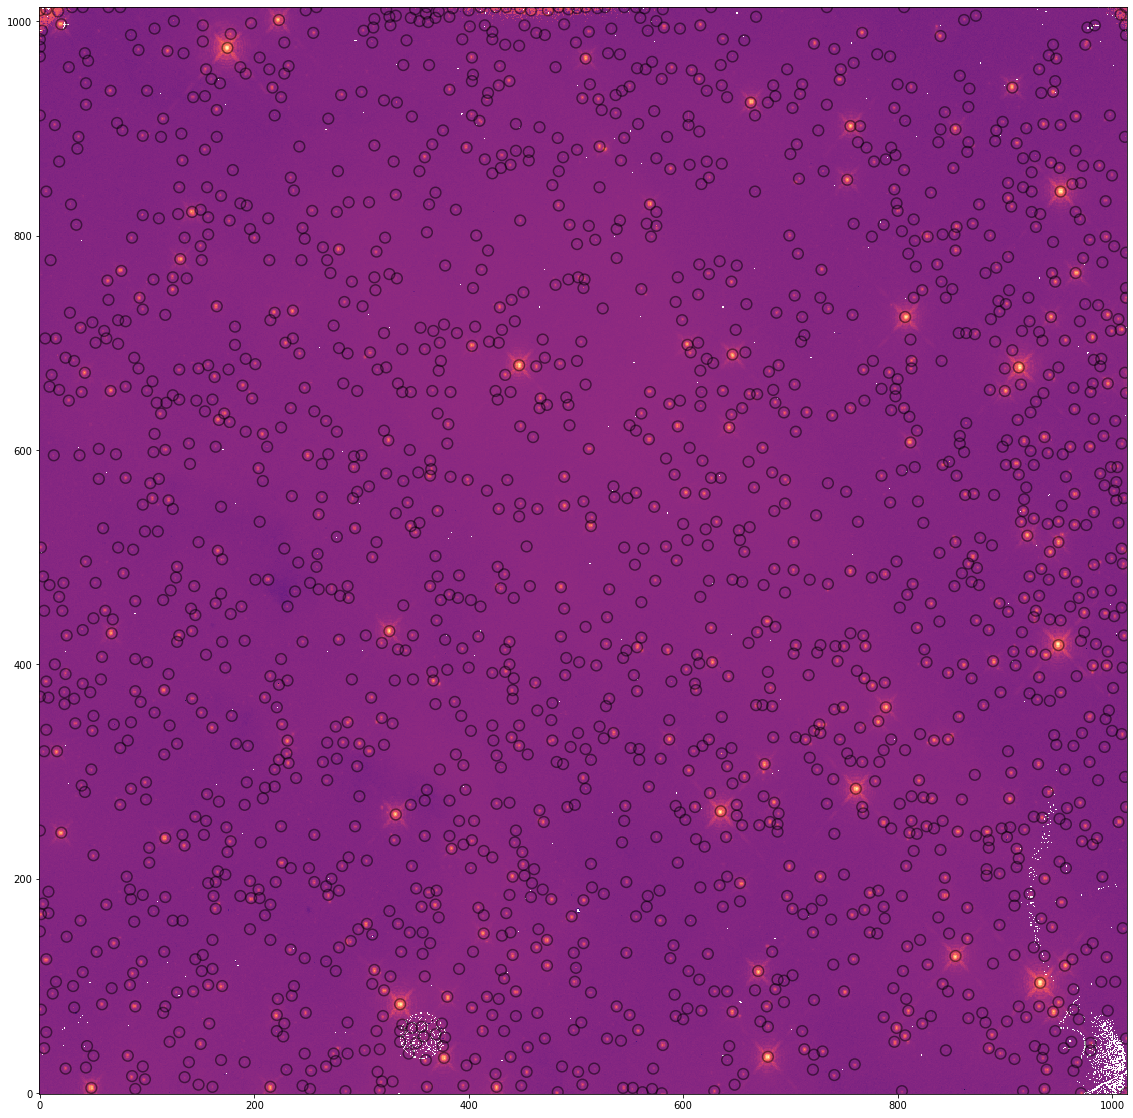

In [54]:
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.)
norm = ImageNormalize(stretch=LogStretch())
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='k', lw=1.5, alpha=0.5)